<a href="https://colab.research.google.com/github/Chromis07/GAN-in-action/blob/main/code/ch2_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 간단한 변이형 오토인코더

[AutoEncoder의 목적은 latent space( =manifold)를 학습하는데 있다.](https://eat-toast.tistory.com/4) <br>
Latent Space란, 특정 차원에서 원하는 정보들이 모여있는 공간이다.

In [2]:
# 기본 임포트
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist

In [3]:
# 하이퍼파라미터 설정하기
batch_size = 100
original_dim = 784 # mnist 이미지 높이 X 너비
latent_dim = 2 # latent space
intermediate_dim = 256 # 중간층. 하지만 다른 크기도 실험해보자
epochs = 50 # 에포크 횟수
epsilon_std = 1.0

## 샘플링 헬퍼 함수 정의하기

[PEP484](https://www.python.org/dev/peps/pep-0484/)를 따라 타입 힌트를 사용하여 함수를 정의합니다.

이 함수를 [람다 함수](https://www.youtube.com/watch?time_continue=48&v=CPFKJRNAje8) 또는 익명의 함수로 사용하기 때문에 매개변수는 튜플이어야 합니다. 

람다는 또 다른 함수이기 때문에 아래 코드에서 두 개의 함수를 정의합니다.

이 책의 포럼에서 Branko Blagojevic가 [제안한 내용](https://forums.manning.com/posts/list/45083.page)을 참고하여 구현했습니다.

함수형 API는 파이썬의 특수 메서드인 __call__() 메서드를 사용합니다. 이 메서드는 객체를 함수처럼 사용할 때 호출됩니다.

In [4]:
# 샘플링 함수 만들기
def sampling(args: tuple):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                            stddev=epsilon_std)
  return z_mean + K.exp(z_log_var / 2) * epsilon

평균과 표준편차를 학습하는 것!
하나의 z가 샘플링 함수를 통해 z_mean, z_log_var와 연결되어 있다.

# 인코더 정의하기

In [5]:
x = Input(shape=(original_dim,), name="input") # 인코더 입력
h = Dense(intermediate_dim, activation='relu', name = 'encoding')(x) # 중간층
z_mean = Dense(latent_dim, name='mean')(h) # 잠재공간의 평균을 정의
z_log_var = Dense(latent_dim, name='log-variance')(h) # 잠재 공간의 로그 분산을 정의

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) # 텐서플로우 백엔드를 사용할 때는 output_shape가 꼭 필요하진 않음

encoder = Model(x, [z_mean, z_log_var, z], name='encoder') # 케라스 모델 인코더 정의

encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            514         encoding[0][0]                   
__________________________________________________________________________________________________
log-variance (Dense)            (None, 2)            514         encoding[0][0]                   
____________________________________________________________________________________________

# 디코더 정의하기

In [7]:
input_decoder = Input(shape=(latent_dim,), name="decoder_input") # 디코더 입력

# 잠재 공간을 중간 층의 차원으로 변환하기
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)

# 원본 차원으로 변환
x_decoded = Dense(original_dim, activation = 'sigmoid', name = 'flat_decoded')(decoder_h)

# 케라스 모델로 디코더를 정의합니다.
decoder = Model (input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder_h (Dense)            (None, 256)               768       
_________________________________________________________________
flat_decoded (Dense)         (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


# 변이형 오토인코더(VAE) 정의하기

In [8]:
# 인코더의 출력을 디코더에 사용합니다. 인코더의 3번째 반환 값이 z
output_combined = decoder(encoder(x)[2])
# 입력과 출력을 연결
vae = Model(x,output_combined)
# 모델 구조를 출력합니다.
vae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [9]:
Model??

## 손실을 정의하고 모델 실행하기!

[KL 손실 (쿨백-라이블러 발산)](https://ko.wikipedia.org/wiki/%EC%BF%A8%EB%B0%B1-%EB%9D%BC%EC%9D%B4%EB%B8%94%EB%9F%AC_%EB%B0%9C%EC%82%B0)과 [binary cross-entropy](https://ko.wikipedia.org/wiki/%EA%B5%90%EC%B0%A8_%EC%97%94%ED%8A%B8%EB%A1%9C%ED%94%BC)를 더하여 전체 loss를 만든다
- KL 발산 : 두 분포 간의 교차 엔트로피와 자기 자신의 엔트로피 간의 차이를 측정하는 것. 혹은 두 분포를 그렸을 때 겹치지 않는 부분이 KL 발산에 비례하는 면적이라고 이해하자

In [14]:
kl_loss = -0.5 * K.sum(
    1 + z_log_var - K.exp(z_log_var) - K.square(z_mean),
    axis = -1)

vae.add_loss(K.mean(kl_loss) / 784.)
vae.compile(optimizer = 'rmsprop', loss = "binary_crossentropy")
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 201988      input[0][0]                      
__________________________________________________________________________________________________
decoder (Functional)            (None, 784)          202256      encoder[0][2]                    
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
______________________________________________________________________________________________

In [15]:
# 훈련/테스트 세트 분할, 입력을 정규화
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [16]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

Epoch 1/50
600/600 [==============================] - 6s 5ms/step - loss: 0.2517
Epoch 2/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2240
Epoch 3/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2189
Epoch 4/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2155
Epoch 5/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2135
Epoch 6/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2122
Epoch 7/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2112
Epoch 8/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2103
Epoch 9/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2097
Epoch 10/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2090
Epoch 11/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2084
Epoch 12/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2078
Epoch 13/50
600/600 [====

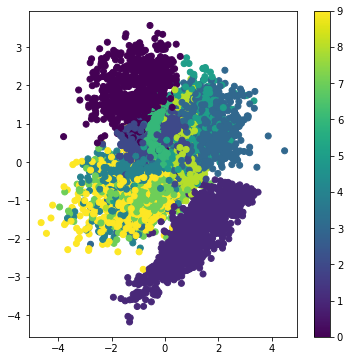

In [17]:
# 잠재 공간에 투영된 숫자 클래스의 2D 그래프
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

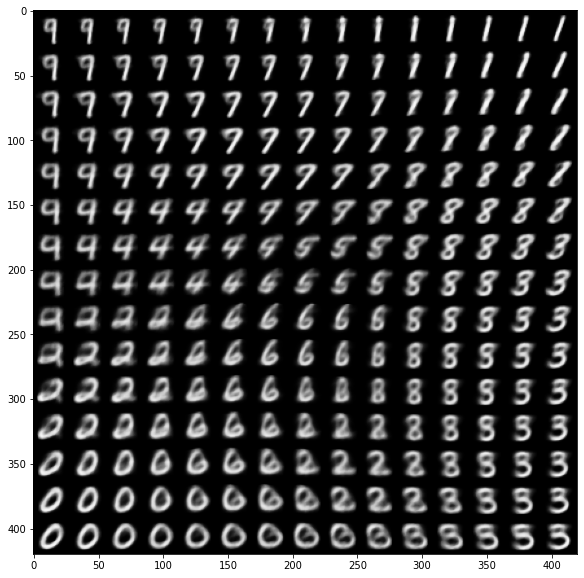

In [18]:
# 숫자의 2D 매니폴드 출력하기
n = 15  # 15x15 숫자를 담은 그림
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# 잠재 공간을 가우스 분포로 가정했기 때문에 잠재 변수 z의 값을 만들기 위해
# 일정 간격으로 떨어진 좌표를 가우스 분포의 역 CDF(ppf)를 통해 변환합니다.
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()